In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)

from xgboost import XGBClassifier
import joblib
import os


In [25]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
df.info()
df['Churn'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [27]:
df.drop(columns=['customerID'], inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)


In [28]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})


In [29]:
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)


In [30]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [31]:
scaler = StandardScaler()

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [32]:
os.makedirs("../models", exist_ok=True)


In [33]:
feature_names = X_train.columns.to_list()

joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(feature_names, "../models/feature_names.pkl")

print("Scaler & feature names berhasil disimpan")
print("Jumlah fitur:", len(feature_names))


Scaler & feature names berhasil disimpan
Jumlah fitur: 45


In [34]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

f1_lr = f1_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_prob_lr)

print("F1 Logistic Regression:", f1_lr)
print("ROC AUC Logistic Regression:", roc_lr)


F1 Logistic Regression: 0.6080305927342257
ROC AUC Logistic Regression: 0.8378408702526728


In [36]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("F1 XGBoost:", f1_xgb)
print("ROC AUC XGBoost:", roc_xgb)


F1 XGBoost: 0.6025437201907791
ROC AUC XGBoost: 0.8114101559398335


In [37]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "F1-Score": [f1_lr, f1_xgb],
    "ROC-AUC": [roc_lr, roc_xgb]
})

results


,Model,F1-Score,ROC-AUC
0,Logistic Regression,0.608031,0.837841
1,XGBoost,0.602544,0.811410


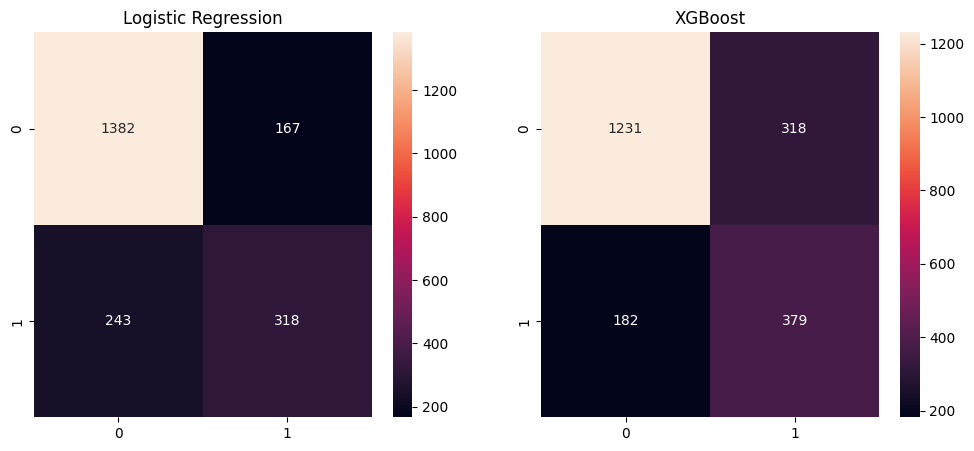

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr),
            annot=True, fmt='d', ax=ax[0])
ax[0].set_title("Logistic Regression")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True, fmt='d', ax=ax[1])
ax[1].set_title("XGBoost")

plt.show()


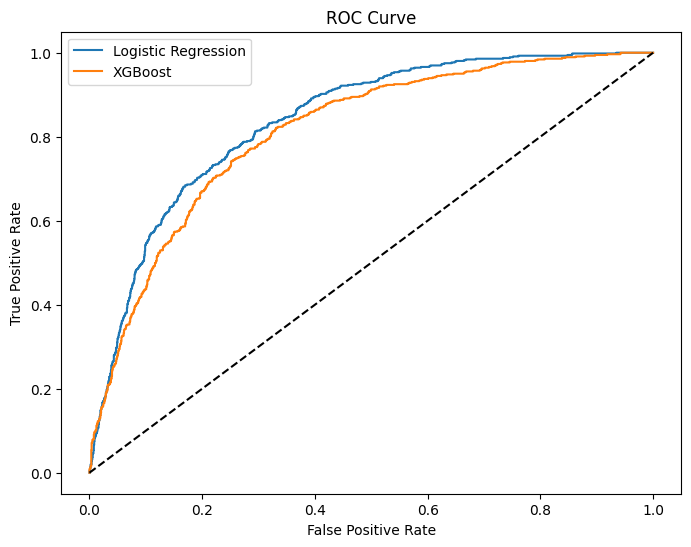

In [39]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


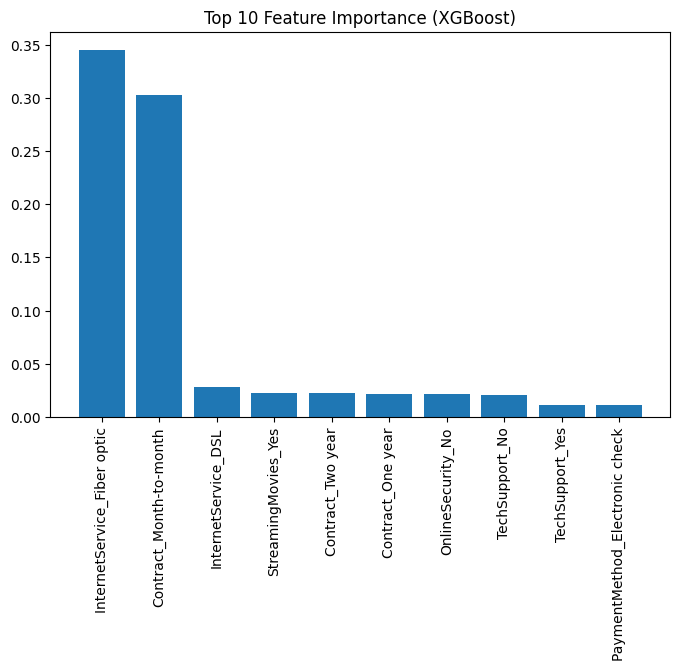

In [40]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8,5))
plt.bar(range(10), importances[indices])
plt.xticks(range(10), X_train.columns[indices], rotation=90)
plt.title("Top 10 Feature Importance (XGBoost)")
plt.show()


In [41]:
joblib.dump(xgb, "../models/xgb_model.pkl")
print("Model XGBoost berhasil disimpan")


Model XGBoost berhasil disimpan
